In [1]:
from UModels import UDHVT
# from UModels import UDHVT_REF
import torch
from torch import nn
import numpy as np
import einops
import matplotlib.pyplot as plt

attention mode is flash


In [2]:
from torchvision import transforms

In [3]:
from PIL import Image

In [7]:
model = UDHVT.UDHVT(num_classes=None, conv=True, refinement=True, skip=True, deconvpatch = False, use_dec = ["DAFF", "MLP", "DDAFF"])

In [9]:
# model

In [4]:
model = UDHVT_REF.UDHVT(img_size = 256,
              patch_size=16, 
              in_chans=3,
              embed_dim = 768,     
              depth=12, 
              num_heads=12,
              mlp_ratio=4, 
              qkv_bias=False, 
              qk_scale=None, 
              norm_layer=nn.LayerNorm,
              mlp_time_embed=True,
              use_checkpoint=False,
              num_classes=None,
              conv=True, skip=True)

In [202]:
import torch
import torch.nn as nn
import math

class DeconvDAFF(nn.Module):
    def __init__(self, in_features, hidden_features=768, out_features=None, act_layer=nn.GELU, drop=0.,
                 kernel_size=3, with_bn=True):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        # pointwise
        self.deconv3 = nn.ConvTranspose2d(out_features, hidden_features, kernel_size=1, stride=1, padding=0)
        self.deconv2 = nn.ConvTranspose2d(
            hidden_features, hidden_features, kernel_size=kernel_size, stride=1,
            padding=(kernel_size - 1) // 2, groups=hidden_features)
        # pointwise
        self.deconv1 = nn.ConvTranspose2d(hidden_features, in_features, kernel_size=1, stride=1, padding=0)
        self.act = act_layer()

        self.bn3 = nn.BatchNorm2d(hidden_features)
        self.bn2 = nn.BatchNorm2d(hidden_features)
        self.bn1 = nn.BatchNorm2d(in_features)

        self.squeeze = nn.AdaptiveAvgPool2d((1, 1))
        self.compress = nn.Linear(in_features, in_features // 4)
        self.excitation = nn.Linear(in_features // 4, in_features)

    def forward(self, x):
        B, N, C = x.size()
        cls_token, tokens = torch.split(x, [1, N - 1], dim=1)

        x = tokens.view(B, C, int(math.sqrt(tokens.size(1))), int(math.sqrt(tokens.size(1)))).permute(0, 2, 3, 1)
        x = x.permute(0, 3, 1, 2)

        x = self.deconv3(x)
        x = self.bn3(x)
        x = self.act(x)

        shortcut = x
        x = self.deconv2(x)
        x = self.bn2(x)
        x = self.act(x)
        x = shortcut + x

        x = self.deconv1(x)
        x = self.bn1(x)

        weight = self.squeeze(x).view(B, 1, C)
        weight = self.excitation(self.act(self.compress(weight)))
        cls_token = cls_token * weight

        tokens = x.flatten(2).permute(0, 2, 1)
        
        out = torch.cat((cls_token, tokens), dim=1)

        return out


In [203]:
xx = torch.rand(1, 257, 768)

In [206]:
yy = DeconvDAFF(in_features=768, hidden_features = 768*5)(xx)

In [207]:
yy.shape

torch.Size([1, 257, 768])

In [208]:
path = r"C:\Users\Admin\Dropbox\PC\Documents\Anomaly Detection\AnoDDPM\diffusion-videos\ARGS=82\Anomalous\DATASETS\Leather\leather\test\poke\004.pngt=383_v=64.png"

In [135]:
path = r"C:\Users\Admin\Pictures\img2box4.png"

In [136]:
image = Image.open(path).convert('RGB')

In [137]:
array = np.array(image)

In [138]:
t = torch.from_numpy(array)

In [139]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image
    transforms.ToTensor()            # Convert the image to a PyTorch tensor
])

In [140]:
t.shape

torch.Size([491, 499, 3])

In [141]:
resized_image = transform(image)

In [142]:
resized_image = resized_image.unsqueeze(0)

In [143]:
resized_image.shape

torch.Size([1, 3, 256, 256])

In [144]:
patches = model.patch_embed.proj(resized_image)

In [148]:
patches.shape

torch.Size([1, 768, 16, 16])

In [164]:
class DeconvPatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        ori_img_size = img_size
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        
        if patch_size[0] == 16:
            self.deconv = torch.nn.Sequential(
                torch.nn.ConvTranspose2d(embed_dim, embed_dim // 2, kernel_size=4, stride=2, padding=1),
                nn.GELU(),
                torch.nn.ConvTranspose2d(embed_dim // 2, embed_dim // 4, kernel_size=4, stride=2, padding=1),
                nn.GELU(),
                torch.nn.ConvTranspose2d(embed_dim // 4, embed_dim // 8, kernel_size=4, stride=2, padding=1),
                nn.GELU(),
                torch.nn.ConvTranspose2d(embed_dim // 8, in_chans, kernel_size=4, stride=2, padding=1)
            )
        elif patch_size[0] == 4:  
            self.deconv = torch.nn.Sequential(
                torch.nn.ConvTranspose2d(embed_dim, embed_dim // 2, kernel_size=4, stride=2, padding=1),
                nn.GELU(),
                torch.nn.ConvTranspose2d(embed_dim // 2, in_chans, kernel_size=4, stride=2, padding=1)
            )
        elif patch_size[0] == 2:  
            self.deconv = torch.nn.Sequential(
                torch.nn.ConvTranspose2d(embed_dim, in_chans, kernel_size=4, stride=2, padding=1),
            )
        else:
            raise ValueError("For convolutional projection, patch size has to be in [2, 4, 16]")

        self.pre_affine = Affine(embed_dim)
        self.post_affine = Affine(in_chans)

    def forward(self, x):
        B, C, H, W = x.shape 

        x = self.pre_affine(x)
        x = self.deconv(x)
        x = self.post_affine(x)

        return x


In [161]:
x_test =torch.rand(1, 768, 16, 16)

In [162]:
y_test = DeconvPatchEmbed()(x_test)

In [163]:
y_test.shape

torch.Size([1, 3, 256, 256])

In [147]:
deconv_layers = torch.nn.Sequential(
    torch.nn.ConvTranspose2d(768, 384, kernel_size=4, stride=2, padding=1),
    nn.GELU(),
    torch.nn.ConvTranspose2d(384, 192, kernel_size=4, stride=2, padding=1),
    nn.GELU(),
    torch.nn.ConvTranspose2d(192, 96, kernel_size=4, stride=2, padding=1),
    nn.GELU(),
    torch.nn.ConvTranspose2d(96, 3, kernel_size=4, stride=2, padding=1)
)


In [149]:
out = deconv_layers(patches)

In [150]:
out.shape

torch.Size([1, 3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 256, 256])
(256, 256, 3)


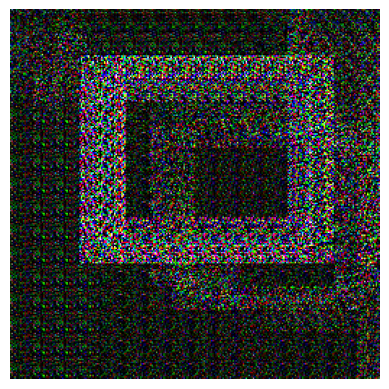

In [152]:
# torch.inverse(model.embeddings.patch_embeddings.projection.weight.data.cpu()).cpu()
# inverse_weights = model1.embeddings.patch_embeddings.projection.weight.data.cpu().cpu()
deconv_layer = nn.ConvTranspose2d(in_channels=768, out_channels=3, kernel_size=(16, 16), stride=(16, 16))


reconstructed_image = deconv_layer(patches)

print(reconstructed_image.shape)

reconstructed_image_np = reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
print(reconstructed_image_np.shape)
# reconstructed_image_np = np.clip(reconstructed_image_np, 0, 1)

plt.imshow(reconstructed_image_np)
plt.axis('off') 
plt.show()

In [3]:

x_test = torch.rand(1, 3, 256, 256)
t = torch.randint(0, 100, (x_test.shape[0],), device=x_test.device)

In [4]:
y_test = model(x_test, t)

torch.Size([1, 257, 768])


In [5]:
y_test

(tensor([[[[0.0000, 0.8136, 0.0000,  ..., 0.1714, 1.3250, 1.4674],
           [1.0693, 1.1340, 0.0000,  ..., 1.2723, 1.0385, 2.4512],
           [0.7132, 1.6477, 0.0000,  ..., 0.7517, 0.7999, 1.1496],
           ...,
           [1.5644, 0.0000, 0.0000,  ..., 0.9167, 0.7524, 0.0000],
           [1.1055, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.9121, 0.1729,  ..., 0.5306, 0.9859, 0.9142]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4258, 0.0000],
           [0.6584, 0.8468, 0.4932,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.4369, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.3175, 0.1066, 0.0000],
           [0.0000, 0.0250, 0.9878,  ..., 0.6889, 0.3021, 0.0000]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 1.7684, 1.7380, 1.3709],
           [0.0000, 0.0000, 0.0000,  ..., 0.5891, 0.5956, 0.0000],
           [0.0000, 0.00

In [47]:
from UModels.UDHVT import *

In [ ]:
class ConvPatchUnembed(nn.Module):
    def __init__(self, patch_size=16, embed_dim=768, in_chans=3):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim  # Make sure this matches your input data
        self.channels = in_chans
        if patch_size == 16:
            # Modify the convolutional layers to match the desired number of channels (in_chans)
            self.unproj = nn.Sequential(
                conv3x3(embed_dim, embed_dim // 2, 2),
                nn.GELU(),
                conv3x3(embed_dim // 2, embed_dim // 4, 2),
                nn.GELU(),
                conv3x3(embed_dim // 4, embed_dim // 8, 2),
                nn.GELU(),
                conv3x3(embed_dim // 8, in_chans, 2),
            )
        # ... Rest of your code


In [72]:
from einops import rearrange

class ConvPatchUnembed(nn.Module):
    def __init__(self, patch_size=16, embed_dim=768, in_chans=3):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = in_chans
        if patch_size == 16:
            self.unproj = nn.Sequential(
                conv3x3(embed_dim, embed_dim // 2, 2),
                nn.GELU(),
                conv3x3(embed_dim // 2, embed_dim // 4, 2),
                nn.GELU(),
                conv3x3(embed_dim // 4, embed_dim // 8, 2),
                nn.GELU(),
                conv3x3(embed_dim // 8, in_chans, 2),
            )
        elif patch_size == 4:
            self.unproj = nn.Sequential(
                conv3x3(embed_dim, embed_dim // 2, 2),
                nn.GELU(),
                conv3x3(embed_dim // 2, in_chans, 2),
            )
        elif patch_size == 2:
            self.unproj = nn.Sequential(
                conv3x3(embed_dim, in_chans, 2),
            )
        else:
            raise ValueError("For convolutional unprojection, patch size has to be in [2, 4, 16]")
        
    def forward(self, x, img_size):
        patch_size = int((x.shape[2] // self.channels) ** 0.5)
        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1] and patch_size ** 2 * self.channels == x.shape[2]

        x = rearrange(x, 'B (h w) (p1 p2 C) -> B C (h p1) (w p2)', h=h, p1=patch_size, p2=patch_size)
        print(x.shape)
        x = self.unproj(x)
        
        return x


In [73]:
import torch

# Sample input data
batch_size = 1
num_channels = 3
image_height = 256
image_width = 256

# Create a random tensor as an example input
embedded_patches = torch.randn(batch_size, 256, 768)  # Assuming 16x16 patches and an embedding dimension of 768

# Create an instance of ConvPatchUnembed
unembedder = ConvPatchUnembed(patch_size=16, embed_dim=768)

# Convert the embedded patches back to the original image
reconstructed_image = unembedder(embedded_patches, (image_width, image_height))


torch.Size([1, 3, 256, 256])


RuntimeError: Given groups=1, weight of size [384, 768, 3, 3], expected input[1, 3, 256, 256] to have 768 channels, but got 3 channels instead